In [371]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sys
import theano.tensor as tt
import seaborn as sns
import scipy.stats as stats
import pymc3 as pm
import logging
(logging.getLogger('theano.gof.compilelock').setLevel(logging.CRITICAL))

%matplotlib inline

We generate some made up spend and transaction data per channel

In [329]:
channels = sorted(['Facebook', 'Google'])
n_channels = len(channels)

campaigns = np.arange(0, 100)

size = len(channels) * len(campaigns)
spend = np.abs(np.random.randn(size)*1000).astype(int)
# spend

In [330]:
cpo_average = np.array([42, 25])
true_intercept = 1
true_slope = 1/cpo_average

# true_transactions = np.ceil(true_intercept + true_slope * spend)
# # add noise
true_sigma = .3
# y = np.round(true_transactions + np.random.normal(scale=true_sigma, size=size), 0)

df = pd.DataFrame([(n, c) for c in campaigns for n in channels], columns=['channel', 'campaign'])

df['channel_id'] = pd.Categorical(df['channel']).codes
channel_idx = df['channel_id']


df.loc[:,'spend'] = spend
df.loc[:,'transactions'] = df.apply(lambda x: np.ceil(x['spend']/cpo_average[x['channel_id']]), axis=1) * (1-
    np.random.normal(scale=true_sigma, size=size))
df.head()

,channel,campaign,channel_id,spend,transactions
0,Facebook,0,0,497,9.488760
1,Google,0,1,355,18.743713
2,Facebook,1,0,1015,23.917214
3,Google,1,1,632,23.662634
4,Facebook,2,0,285,9.976660


In [357]:
df.sample(10)

,channel,campaign,channel_id,spend,transactions
56,Facebook,28,0,1638,33.267437
52,Facebook,26,0,1306,33.981290
73,Google,36,1,1642,51.227084
100,Facebook,50,0,294,7.660961
102,Facebook,51,0,1398,56.061005
64,Facebook,32,0,1030,23.331191
2,Facebook,1,0,1015,23.917214
126,Facebook,63,0,1048,14.579345
155,Google,77,1,744,36.530866
75,Google,37,1,1498,50.562713


In [331]:
df.describe()

,campaign,channel_id,spend,transactions
count,200.000000,200.000000,200.000000,200.000000
mean,49.500000,0.500000,867.385000,26.309364
std,28.938507,0.501255,572.486358,18.799130
min,0.000000,0.000000,33.000000,0.984636
25%,24.750000,0.000000,404.000000,11.313316
50%,49.500000,0.500000,740.500000,23.441856
75%,74.250000,1.000000,1254.250000,36.539050
max,99.000000,1.000000,3219.000000,91.798678


In [332]:
df.groupby('channel')['transactions'].mean()

channel
Facebook    21.718490
Google      30.900238
Name: transactions, dtype: float64

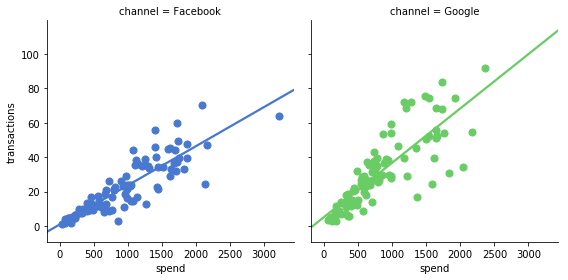

In [333]:
sns.lmplot(x="spend", y="transactions", col="channel", hue="channel", data=df,
           col_wrap=2, ci=None, palette="muted", size=4,
           scatter_kws={"s": 50, "alpha": 1});

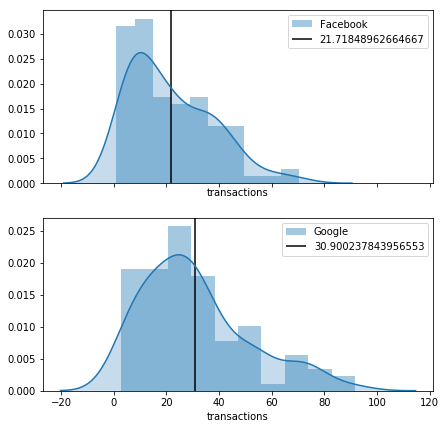

In [356]:

f, axes = plt.subplots(2, 1, figsize=(7, 7), sharex=True)

i = 0
for c, d in df.groupby('channel'):
    sns.distplot(d['transactions'], hist=True, bins=10, kde_kws={"shade": True}, ax=axes[i], label=c)
    axes[i].vlines(d['transactions'].mean(), 0 , 1, label=d['transactions'].mean())
    axes[i].legend()
    i += 1


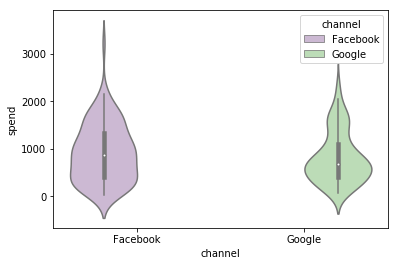

In [335]:
sns.violinplot(x='channel', y="spend", hue="channel", data=df, palette="PRGn");

In [336]:
g_ = df.groupby('channel')['spend'].sum()/df.groupby('channel')['transactions'].sum()
g_

channel
Facebook    42.327069
Google      26.391059
dtype: float64

In [337]:
g_[g_.index == 'Facebook'].values[0]

42.32706858547496

- We model the unobserved (latent) cost per transaction $c$ as a _Uniform_ prior (or alternatively as an Exponential)
- The expected transactions $e$ are modeled deterministically as the observed spend / latent distribution of cost/transaction
- The likelihood of the observed transactions is modeled as a _Poission_ distribution with $mu = e$

In [417]:
model = pm.Model()

with pm.Model() as model:

#     # prior on scale
# #     lam = pm.HalfCauchy('scale', 10)

#     # channel effects
#     cost_per_transaction = pm.Uniform('cost_per_transaction', 0, 10000, shape=n_channels)
# #     cost_per_transaction = pm.Exponential('cost_per_transaction', 1/lam, shape=n_channels)
# #     cost_per_transaction = pm.Uniform('cost_per_transaction', 1, 10000, shape=n_channels)
    
#     expected_transactions = pm.Deterministic('expected_transactions', 
                                             
#                                             )  
    
#     # The observed number of transactions is a Poisson with mu set to the expectations
#     transactions = pm.Poisson('transactions', mu=expected_transactions, observed=df['transactions'].values)
    
    
    cpo_obs = df['spend'].sum()/df['transactions'].sum()
    cpo_obs_sd = (df['spend']/df['transactions']).std()
    
    cpo = pm.Normal('cpo', mu=cpo_obs, sd=cpo_obs_sd)
    cpo_sigma_store = pm.HalfCauchy('cpo_sigma_store', 10)
    cpo_channel = pm.Normal('cpo_channel', mu=cpo, sd=cpo_sigma_store, shape=n_channels)
    
#     sigma = pm.HalfCauchy('sigma', 10)
    transactions = pm.Poisson('transactions', 
                            mu=df['spend'].values/cpo_channel[channel_idx], 
#                             sd=sigma, 
                            observed=df['transactions'].values)

In [418]:
model

In [419]:
n_samples = 20000
n_chains = 3
seed = 22
SAMPLE_KWARGS = {
    'draws': n_samples,
    'tune': int(n_samples/2),
    'njobs': n_chains,
    'random_seed': [seed + i for i in range(n_chains)],
    'nuts_kwargs': {'target_accept': 0.9}
}
with model:
    trace = pm.sample(**SAMPLE_KWARGS)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/Users/claus/anaconda3/lib/python3.6/site-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [cpo_channel, cpo_sigma_store_log__, cpo]
100%|██████████| 30000/30000 [01:03<00:00, 470.46it/s]
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.


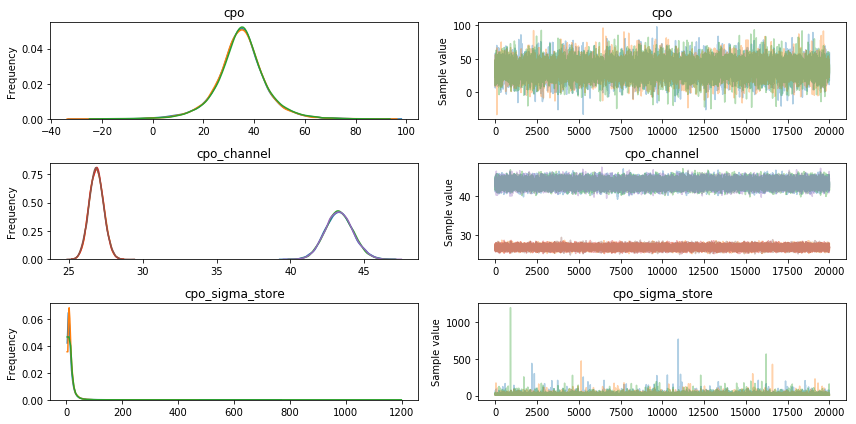

In [421]:
pm.traceplot(trace);

Check the Gelman-Rubin stat, we want it to be ~1

In [422]:
max(np.max(gr_stats) for gr_stats in pm.gelman_rubin(trace).values()), min(np.min(eff_stats) for eff_stats in pm.effective_n(trace).values())

(1.0001565643621921, 26127.0)

We plot the distributions of the cost per transaction, along with the observed values to see if the model returned reasonable distributions.

We notice that for channels with lower volume, the distributions show some (expected) skew.

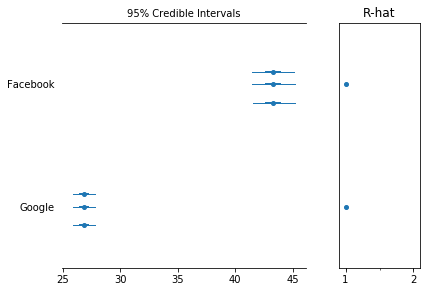

In [423]:
pm.forestplot(trace, varnames=['cpo_channel'], ylabels=channels);

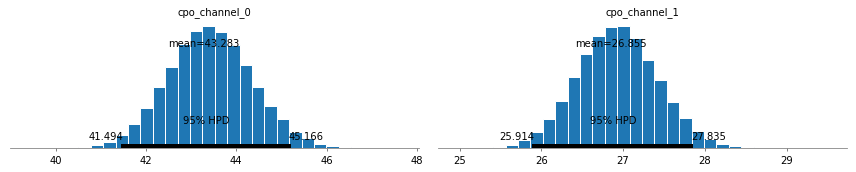

In [424]:
with model:
    pm.plot_posterior(trace, varnames=['cpo_channel'])

In [425]:
trace['cpo_channel'][:, 0].mean(), trace['cpo_channel'][:, 1].mean()

(43.283344263410704, 26.855059366998766)

0 Facebook


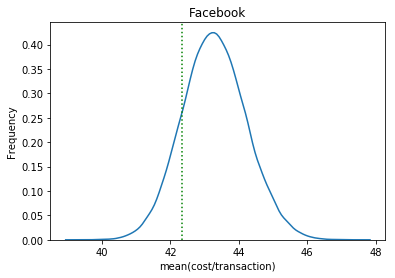

1 Google


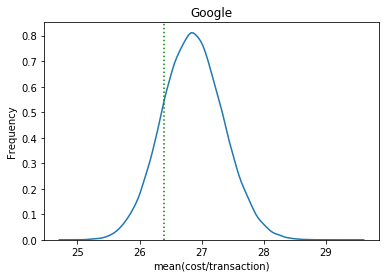

In [426]:
for i, c in enumerate(channels):
    print(i, c)
    
    obs_mean = df.query(f"channel == '{c}'")['spend'].mean()/df.query(f"channel == '{c}'")['transactions'].mean()
    
    dt = trace['cpo_channel'][:, i]
    ax = plt.subplot()
    sns.distplot(dt, kde=True, hist=False, ax=ax)
    ax.axvline(obs_mean, c='g', linestyle='dotted')
    ax.set(title=f'{c}', xlabel='mean(cost/transaction)', ylabel='Frequency');
    plt.show()

To get the posterior of the transactions, we sample from the posterior for each channel

In [427]:
with model:
    ppc = pm.sample_ppc(trace)

100%|██████████| 20000/20000 [00:04<00:00, 4064.54it/s]


Then we plot the distributions for each channel along with the observed values:

In [428]:
ppc['transactions']

array([[10, 17, 24, ...,  8, 10,  3],
       [ 9, 13, 23, ..., 12, 11,  3],
       [19,  8, 22, ..., 13,  9,  4],
       ...,
       [16, 18, 19, ..., 11, 15,  3],
       [ 4, 13, 28, ..., 12,  6,  6],
       [15, 16, 22, ..., 18, 12,  3]])

11.5187


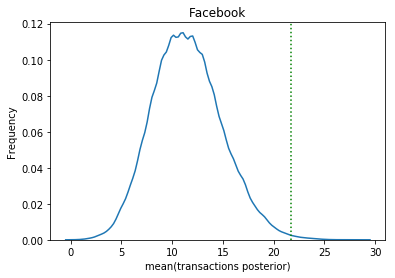

13.2363


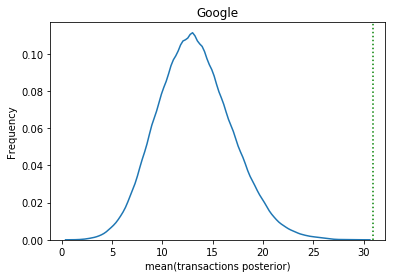

In [429]:
for i, c in enumerate(channels):
#     print(i, c)
    dt = ppc['transactions'][:, i]
    print(dt.mean())
    obs_mean = df.query(f"channel == '{c}'")['transactions'].mean()
    
    ax = plt.subplot()
    sns.distplot(dt, 
                 kde=True, hist=False, ax=ax)
    ax.axvline(obs_mean, c='g', linestyle='dotted', label=obs_mean)
    ax.set(title=f'{c}', xlabel='mean(transactions posterior)', ylabel='Frequency')
#     plt.legend(loc='best')
    plt.show()